In [ ]:
import torch
import torch.utils.data as data
from PIL import Image
import nltk
import os
from vocabulary import Vocabulary
from vocabulary import CocoDataset

In [74]:
# Define a function to create batches from a list of tuples (image, caption)
def collate_fn(data):
    # Sort data by caption length in descending order for efficient packing and padding
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, captions = zip(*data)

    # Merge images from tuple of 3D tensors to a 4D tensor (batch size, color channels, height, width)
    images = torch.stack(images, 0)

    # Create a tensor to hold the padded captions with maximum length in the batch
    lengths = [len(caption) for caption in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()

    # Fill the tensor with caption tokens; padding will be automatically added where necessary
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end]

    return images, targets, lengths  # Return the batched images, padded captions, and lengths of each caption

# Define a separate collate function for testing where we don't want to sort the captions
def collate_fn_test(data):
    # Keep the order of data as is (useful during testing)
    images, captions = zip(*data)

    # Merge images into a 4D tensor as before
    images = torch.stack(images, 0)

    # Create a tensor for the padded captions as before
    lengths = [len(caption) for caption in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()

    # Pad the captions with the original tokens up to the length of each caption
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end]

    return images, targets, lengths  # Return images, padded captions, and lengths as before

# Function to get a data loader for custom Flickr8k dataset
def get_loader(root, captions, vocab, transform, batch_size, shuffle, num_workers, testing):
    # CocoDataset 초기화
    coco_dataset = CocoDataset(root=root, captions=captions, vocab=vocab, transform=transform)

    # 테스트 중인지에 따라 적절한 collate 함수 선택
    collate_fn_to_use = collate_fn_test if testing else collate_fn

    # DataLoader를 반환합니다.
    data_loader = torch.utils.data.DataLoader(dataset=coco_dataset,
                                              batch_size=batch_size,
                                              shuffle=shuffle,
                                              num_workers=num_workers,
                                              collate_fn=collate_fn_to_use)
    return data_loader

In [75]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence


class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        # 사전 학습된(pre-trained) ResNet-101을 불러와 FC 레이어를 교체
        super(EncoderCNN, self).__init__()
        transfer_model = models.resnet101(pretrained=True)
        modules = list(transfer_model.children())[:-1] # 마지막 FC 레이어를 제거
        self.transfer_model = nn.Sequential(*modules)
        self.embed = nn.Linear(transfer_model.fc.in_features, embed_size) # 결과(output) 차원을 임베딩 차원으로 변경
        self.batch_norm = nn.BatchNorm1d(embed_size, momentum=0.01)

    def forward(self, images):
        # 입력 이미지에서 특징 벡터(feature vectors)
        with torch.no_grad(): # 네트워크의 앞 부분은 변경되지 않도록 하기
            features = self.transfer_model(images)
        features = features.reshape(features.size(0), -1)
        features = self.batch_norm(self.embed(features))
        return features


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        # 하이퍼 파라미터(hyper-parameters) 설정 및 레이어 생성
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seg_length = max_seq_length

    def forward(self, features, captions, lengths):
        # 이미지 특징 벡터(feature vectors)로부터 캡션(caption) 생성
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1) # 이미지 특징과 임베딩 연결
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) # 패딩을 넣어 차원 맞추기
        hiddens, _ = self.lstm(packed) # 다음 hidden state 구하기
        outputs = self.linear(hiddens[0])
        return outputs

    def sample(self, features, states=None):
        # 간단히 그리디(greedy) 탐색으로 캡션(caption) 생성하기
        sampled_indexes = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seg_length):
            hiddens, states = self.lstm(inputs, states) # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1)) # outputs: (batch_size, vocab_size)
            _, predicted = outputs.max(1) # predicted: (batch_size)
            sampled_indexes.append(predicted)
            inputs = self.embed(predicted) # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1) # inputs: (batch_size, 1, embed_size)
        sampled_indexes = torch.stack(sampled_indexes, 1) # sampled_indexes: (batch_size, max_seq_length)
        return sampled_indexes

In [76]:
img_dir = ["./dataset/train/images", "./dataset/val/images", "./dataset/test/images"] 

image_paths = "./train2017" # original image
train_img_path = img_dir[0] # resized image for training
val_img_path = img_dir[1] # resized image for validation
test_img_path = img_dir[2] # resized image for test
size = [256, 256]

coco_caption_path = "./annotations/captions_train2017.json"
train_caption_path = "./dataset/train/captions.txt" # resized image for training
val_caption_path = "./dataset/val/captions.txt" # resized image for validation
test_caption_path = "./dataset/test/captions.txt" # resized image for test
vocab_path = "./dataset/vocab.pkl"  # Path to the preprocessed vocabulary file
word_threshold = 8

In [78]:
import os
import pickle
import torch
from torchvision import transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_path = "models/"  # Path where the trained model will be saved

# Create model directory
if not os.path.exists(model_path):
    os.makedirs(model_path)

# Load vocabulary file
with open(vocab_path, 'rb') as f:
    vocab = pickle.load(f)

# Use the same preprocessing and normalization parameters as were applied in the pre-trained Inception model.
train_transform = transforms.Compose([
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

val_transform = transforms.Compose([
    transforms.Resize(224),  # Adjust to the correct size for Inception
    #transforms.CenterCrop(230),  # Ensure the image is 299x299
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

test_transform = transforms.Compose([
    transforms.Resize(224),  # Adjust to the correct size for Inception
    #transforms.CenterCrop(230),  # Ensure the image is 299x299
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

batch_size = 128
num_workers = 2

# Declare data loaders
train_data_loader = get_loader(train_img_path, train_caption_path, vocab, train_transform, batch_size, shuffle=True, num_workers=num_workers, testing=False)
val_data_loader = get_loader(val_img_path, val_caption_path, vocab, val_transform, batch_size, shuffle=False, num_workers=num_workers, testing=False)
test_data_loader = get_loader(test_img_path, test_caption_path, vocab, test_transform, batch_size, shuffle=False, num_workers=num_workers, testing=True)


In [79]:
# Increase Model Capacity
embed_size = 256
hidden_size = 512
num_layers = 1  # More layers can capture complex patterns

encoder = EncoderCNN(embed_size).to(device)
decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers).to(device)

num_epochs = 10
learning_rate = 0.001

processing_step = 40
model_saving_step = 1000

# Assuming that encoder and decoder are defined and moved to the device
# and that train_data_loader is already defined

# Criterion with ignore_index to skip pad tokens
criterion = nn.CrossEntropyLoss(ignore_index=vocab('<pad>'))
params = list(decoder.parameters()) + list(encoder.embed.parameters()) + list(encoder.batch_norm.parameters())
optimizer = torch.optim.Adam(params, lr=learning_rate)

In [80]:
from tqdm import tqdm

# Gradient clipping value
clip_value = 5

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Training loop
for epoch in range(num_epochs):
    # 여기에 tqdm을 추가합니다. 이는 train_data_loader의 각 배치에 대한 진행 상태를 표시합니다.
    with tqdm(enumerate(train_data_loader), total=len(train_data_loader), desc=f'Epoch {epoch + 1}/{num_epochs}') as t:
        for i, (images, captions, lengths) in t:
            # Move batch of images and captions to GPU if available
            images, captions = images.to(device), captions.to(device)

            # Forward pass through encoder and decoder
            features = encoder(images)
            outputs = decoder(features, captions, lengths)
            targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]

            # Calculate the batch loss based on the criterion
            loss = criterion(outputs, targets)
            decoder.zero_grad()
            encoder.zero_grad()

            # Backward pass (compute gradients)
            loss.backward()

            # Clip gradients
            torch.nn.utils.clip_grad_norm_(params, clip_value)

            # Update the weights
            optimizer.step()

            # Update tqdm's description with the current loss
            t.set_postfix(loss=loss.item())

            # Log training statistics and save model checkpoints
            if i % processing_step == 0 & epoch % 5 == 0:
                torch.save(decoder.state_dict(), os.path.join(model_path, 'decoder-{}-{}.ckpt'.format(epoch+1, i)))
                torch.save(encoder.state_dict(), os.path.join(model_path, 'encoder-{}-{}.ckpt'.format(epoch+1, i)))


Epoch 1/10:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10/10: 100%|██████████| 79/79 [00:20<00:00,  3.79it/s, loss=1.88]


In [81]:
import os

artwork=[]
folder_path = './dataset/test/images'

for file_name in os.listdir(folder_path):
    file_path = os.path.join(folder_path, file_name)

    artwork.append(file_path) # folder_path => file_path 수정

In [82]:
def load_image(image_path, transform=None):
    image = Image.open(image_path).convert('RGB')
    image = image.resize([256, 256], Image.LANCZOS)

    if transform is not None:
        image = transform(image).unsqueeze(0)

    return image

image_path = artwork[5] # input images
encoder_path = 'models/encoder-10-0.ckpt' # path for trained encoder
decoder_path = 'models/decoder-10-0.ckpt' # path for trained decoder
vocab_path = "./dataset/vocab.pkl" # path for vocabulary wrapper

#Params
embed_size = 256
hidden_size = 512
num_layers = 1  # More layers can capture complex patterns

In [83]:
# Image preprocessing
transform = transforms.Compose([
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# Load vocabulary wrapper
with open(vocab_path, 'rb') as f:
    vocab = pickle.load(f)

# Build models
encoder = EncoderCNN(embed_size).eval() # eval mode (batchnorm uses moving mean/variance)
decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers)
encoder = encoder.to(device)
decoder = decoder.to(device)

# Load the trained model parameters
encoder.load_state_dict(torch.load(encoder_path))
decoder.load_state_dict(torch.load(decoder_path))

# Prepare an image
image = load_image('./dataset/test/images/000000012574.jpg', transform)
image_tensor = image.to(device)

# Generate an caption from the image
feature = encoder(image_tensor)
sampled_ids = decoder.sample(feature)
sampled_ids = sampled_ids[0].cpu().numpy() # (1, max_seq_length) -> (max_seq_length)

# Convert word_ids to words
predicted_caption = []
for word_id in sampled_ids: # 하나씩 단어 인덱스를 확인하며
    word = vocab.idx2word[word_id] # 단어 문자열로 바꾸어 삽입
    predicted_caption.append(word)
    if word == '<end>':
        break
sentence = ' '.join(predicted_caption)

<ipython-input-82-64bf08a6186b>:3: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  image = image.resize([256, 256], Image.LANCZOS)


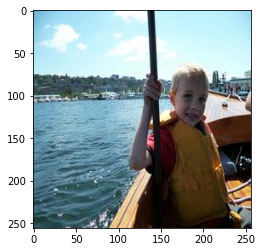

<start> a man is riding a surfboard on a wave . <end>


In [84]:
import matplotlib.pyplot as plt
import numpy as np
image = Image.open('./dataset/test/images/000000012574.jpg')
plt.imshow(np.asarray(image))
plt.show()
print(sentence)